# Rupaul's Drag Race Machine

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pandas as pd
import numpy as np
import math, random
from scipy.stats import rankdata, kendalltau
from sklearn.preprocessing import scale

theData = pd.read_csv("dragrace.csv")
theData= theData.fillna(0)
#theData.iloc[1:10,:]

In [2]:
queens = theData
queens.shape

(129, 22)

In [3]:
# create a function to scale the data for us
def scaleQueens(df):
    """Scale Age, Wins, Highs, Lows, and Lipsyncs in feature data frames"""
    df = df.copy(deep=True)
    df['Age'] = scale(df['Age'])
    df['Wins'] = scale(df['Wins'])
    df['Highs'] = scale(df['Highs'])
    df['Lows'] = scale(df['Lows'])
    df['Lipsyncs'] = scale(df['Lipsyncs'])
    df['Season'] = df['Season']/9
    return df

In [4]:
def compareRanks(x,y):
    """x = actual, y = predicted place"""
    x=np.asarray(x)
    y=np.asarray(y)
    numRanks = np.append(x,y).max()
    actual=np.sum(np.square(x-y))
    worst=np.sum(np.square(np.sort(x)-np.sort(x)[::-1]))
    return 1-2*(actual/worst)

In [5]:
def rankScore(model,x,y):
    ypred = model.predict(x)
    score = compareRanks(y,ypred)
    return score

In [6]:
def createPD(s,queens,yfitpd):
    season = queens.loc[queens.Season==s,['Name','Place']]
    seasonpred = yfitpd.loc[queens.Season==s]
    season['Predicted'] = seasonpred
    season['Predicted'] = rankdata(season.Predicted,method='min')
    season = season.sort_values('Place')
    return season

In [7]:
def predictSeason(season,model,queens,scaled=False):
    Xtrain = queens.loc[queens.Season!=season,['Age','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    Xtest = queens.loc[queens.Season==season,['Age','PlusSize','Wins','Highs','Lows','Lipsyncs','Season']]
    ytrain = queens.loc[queens.Season!=season,'Place']
    if scaled:
        Xtrain = scaleQueens(Xtrain)
        Xtest = scaleQueens(Xtest)
    model.fit(Xtrain,ytrain)
    yfit = model.predict(Xtest)
    pddf = queens.loc[queens.Season==season,['Name','Place']]
    pddf['Predicted'] = rankdata(yfit,method='min')
    return pddf

In [8]:

class neural_network:
    """Defines a neural network, along with attributes for fitting and predicting the network"""
    def __init__(self,size):
        random.seed(0)
        self.network = []
        for i in range(1,len(size)):
            self.network.append([[random.random() for __ in range(size[i-1] + 1)] for __ in range(size[i])])
    
    def sigmoid(self,t): 
        return 1 / (1 + math.exp(-t))
    
    def neuron_output(self,weights, inputs):   #This is a simpler representation; weights for input plus one extra (bias)
        return self.sigmoid(np.dot(weights, inputs))
    
    def feed_forward(self,input_vector):
        outputs = []

        for layer in self.network: #Remember the neural network is given as a list of "layers" which have neurons in them

            input_with_bias = input_vector + [1]          # add a bias input (this just allos us to use a dot product)
            output = [self.neuron_output(neuron, input_with_bias) # compute the output
                      for neuron in layer]                   # for this layer
            outputs.append(output)                           # and remember it

            # the input to the next layer is the output of this one
            input_vector = output

        return outputs
    
    def predict(self,X):
        X = scaleQueens(X)
        predictedY = []
        X = X.values.tolist()
        for i, input in enumerate(X):
            outputs = self.feed_forward(input)[-1]
            predictedY.append(outputs)
        predictedPlace = [a.index(max(a)) for a in predictedY]
        return predictedPlace
    
    
    def convertY(self,Y):
        yNN = [[1 if i == (j-1) else 0 for i in range(0,len(Y)-1)]
               for j in Y ]
        return(yNN)
    
    # define the back-propagation that allows the network to learn
    def backpropagate(self, input_vector, target):
        hidden_outputs, outputs = self.feed_forward(input_vector)

        # the output * (1 - output) is from the derivative of sigmoid
        output_deltas = [output * (1 - output) * (output - target[i])
                         for i, output in enumerate(outputs)]

        # adjust weights for output layer (network[-1])
        for i, output_neuron in enumerate(self.network[-1]):
            for j, hidden_output in enumerate(hidden_outputs + [1]):
                output_neuron[j] -= output_deltas[i] * hidden_output

        # back-propagate errors to hidden layer
        hidden_deltas = [hidden_output * (1 - hidden_output) * 
                          np.dot(output_deltas, [n[i] for n in self.network[-1]]) 
                         for i, hidden_output in enumerate(hidden_outputs)]

        # adjust weights for hidden layer (network[0])
        for i, hidden_neuron in enumerate(self.network[0]):
            for j, input in enumerate(input_vector + [1]):
                hidden_neuron[j] -= hidden_deltas[i] * input
    
    def fit(self,features,targets,times=10000):
        features = scaleQueens(features)
        targets = self.convertY(targets)
        features = features.values.tolist()
        for i in range(times):
            for X, Y in zip(features, targets):
                self.backpropagate(X,Y)
        
        
        

In [9]:
def setXY(x,y,n):
    """Get appropriate x,y coords in cases of ties"""
    y = y - int((n-1)/3)*0.8
    if n % 3 == 2:
        x = x - 0.33
    elif n % 3 == 0:
        x = x + 0.33
    return(x,y)

Initialize the models

In [10]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier

svc_model = SVC(kernel='rbf',gamma=0.01,C=10)
gnb_model = GaussianNB()
rfc_model = RandomForestClassifier(n_estimators=100, random_state=0)
rfr_model = RandomForestRegressor(200,random_state=24601)
nn2_model=MLPClassifier(hidden_layer_sizes=(5,14,),
                       activation='logistic',
                       solver='lbfgs',
                       random_state=24601)

Have each model predict the rankings and save to a data frame


In [11]:
#predictSeason(10,nn2_model,queens,True)

In [12]:
season_to_predict = 10
the_models = [gnb_model,rfc_model,rfr_model,nn2_model]
model_names = ["GNB","RFC","RFR","NN"]
season = predictSeason(season_to_predict,svc_model,queens,True)
season['Season'] = season_to_predict
season['Model'] = 'SVC'
rank_score = compareRanks(season.Place,season.Predicted)
rsdf = pd.DataFrame({'Season': [season_to_predict], 'Value': [rank_score], 'Model': ['SVM']})
pred_df = season
rank_scores = rsdf.copy(deep=True)
n = 0
for model in the_models:
    season = predictSeason(season_to_predict,model,queens,True)
    season['Season'] = season_to_predict
    season['Model'] = model_names[n]
    pred_df = pred_df.append(season)
    rank_score = compareRanks(season.Place,season.Predicted)
    rsdf = pd.DataFrame({'Season': [season_to_predict], 'Value': [rank_score], 'Model': [model_names[n]]})
    rank_scores = rank_scores.append(rsdf)
    n += 1


/Users/telliott27/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/telliott27/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/telliott27/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [13]:
resultsTable = pred_df.pivot_table(index=('Name','Place','Season'),columns='Model').sortlevel(['Season','Place'])
resultsTable = resultsTable.reset_index()
resultsTable['mean'] = resultsTable.Predicted.mean(axis=1)
resultsTable['PredPlace'] = rankdata(resultsTable['mean'],method='min')
resultsTable.to_csv('PredictedSeason10.csv')
resultsTable.sort_values(by='mean')

/Users/telliott27/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  """Entry point for launching an IPython kernel.


Name Place Season Predicted                  \
Model                                                  GNB  NN RFC RFR SVC   
7                     Mayhem Miller   0.0     10         1   1   1   1   1   
11                        The Vixen   0.0     10         1   1   1   2   1   
2                   Blair St. Clair   0.0     10         1   1   3   4   6   
8                       Miz Cracker   0.0     10         1   7   5   3   3   
3                 Dusty Ray Bottoms   0.0     10        10   4  11   6   4   
10                    Monique Heart   0.0     10        10   4  11   7   4   
9                    Monet X Change   0.0     10         1   9   8   8  11   
13                   Yuhua Hamasaki   0.0     10         1   9   8   8  11   
6                  Kameron Michaels   0.0     10         1  12  10   5  11   
0                           Aquaria   0.0     10         1   4  13  13  10   
5      Kalorie Karbdashian-Williams  13.0     10        12   8   5  11   7   
12             Vanessa Vanjie Mateo  14.0     10        12  11   3  10   7   
4                     Eureka O'Hara   0.0     10        12  13   5  12   7   
1                       Asia O'Hara   0.0     10         1  13  14  14  14   

       mean PredPlace  
Model                  
7       1.0         1  
11      1.2         2  
2       3.0         3  
8       3.8         4  
3       7.0         5  
10      7.2         6  
9       7.4         7  
13      7.4         7  
6       7.8         9  
0       8.2        10  
5       8.6        11  
12      8.6        11  
4       9.8        13  
1      11.2        14

In [14]:
rank_scores

,Model,Season,Value
0,SVM,10,-1.389041
0,GNB,10,0.019178
0,RFC,10,-1.961644
0,RFR,10,-1.183562
0,NN,10,-1.131507


In [15]:
compareRanks(resultsTable.Place,resultsTable.PredPlace)

-1.0493150684931507

In [16]:
df = theData.loc[theData.Season==season_to_predict,['Name','filename']]
filenames = df.set_index('Name').to_dict()['filename']

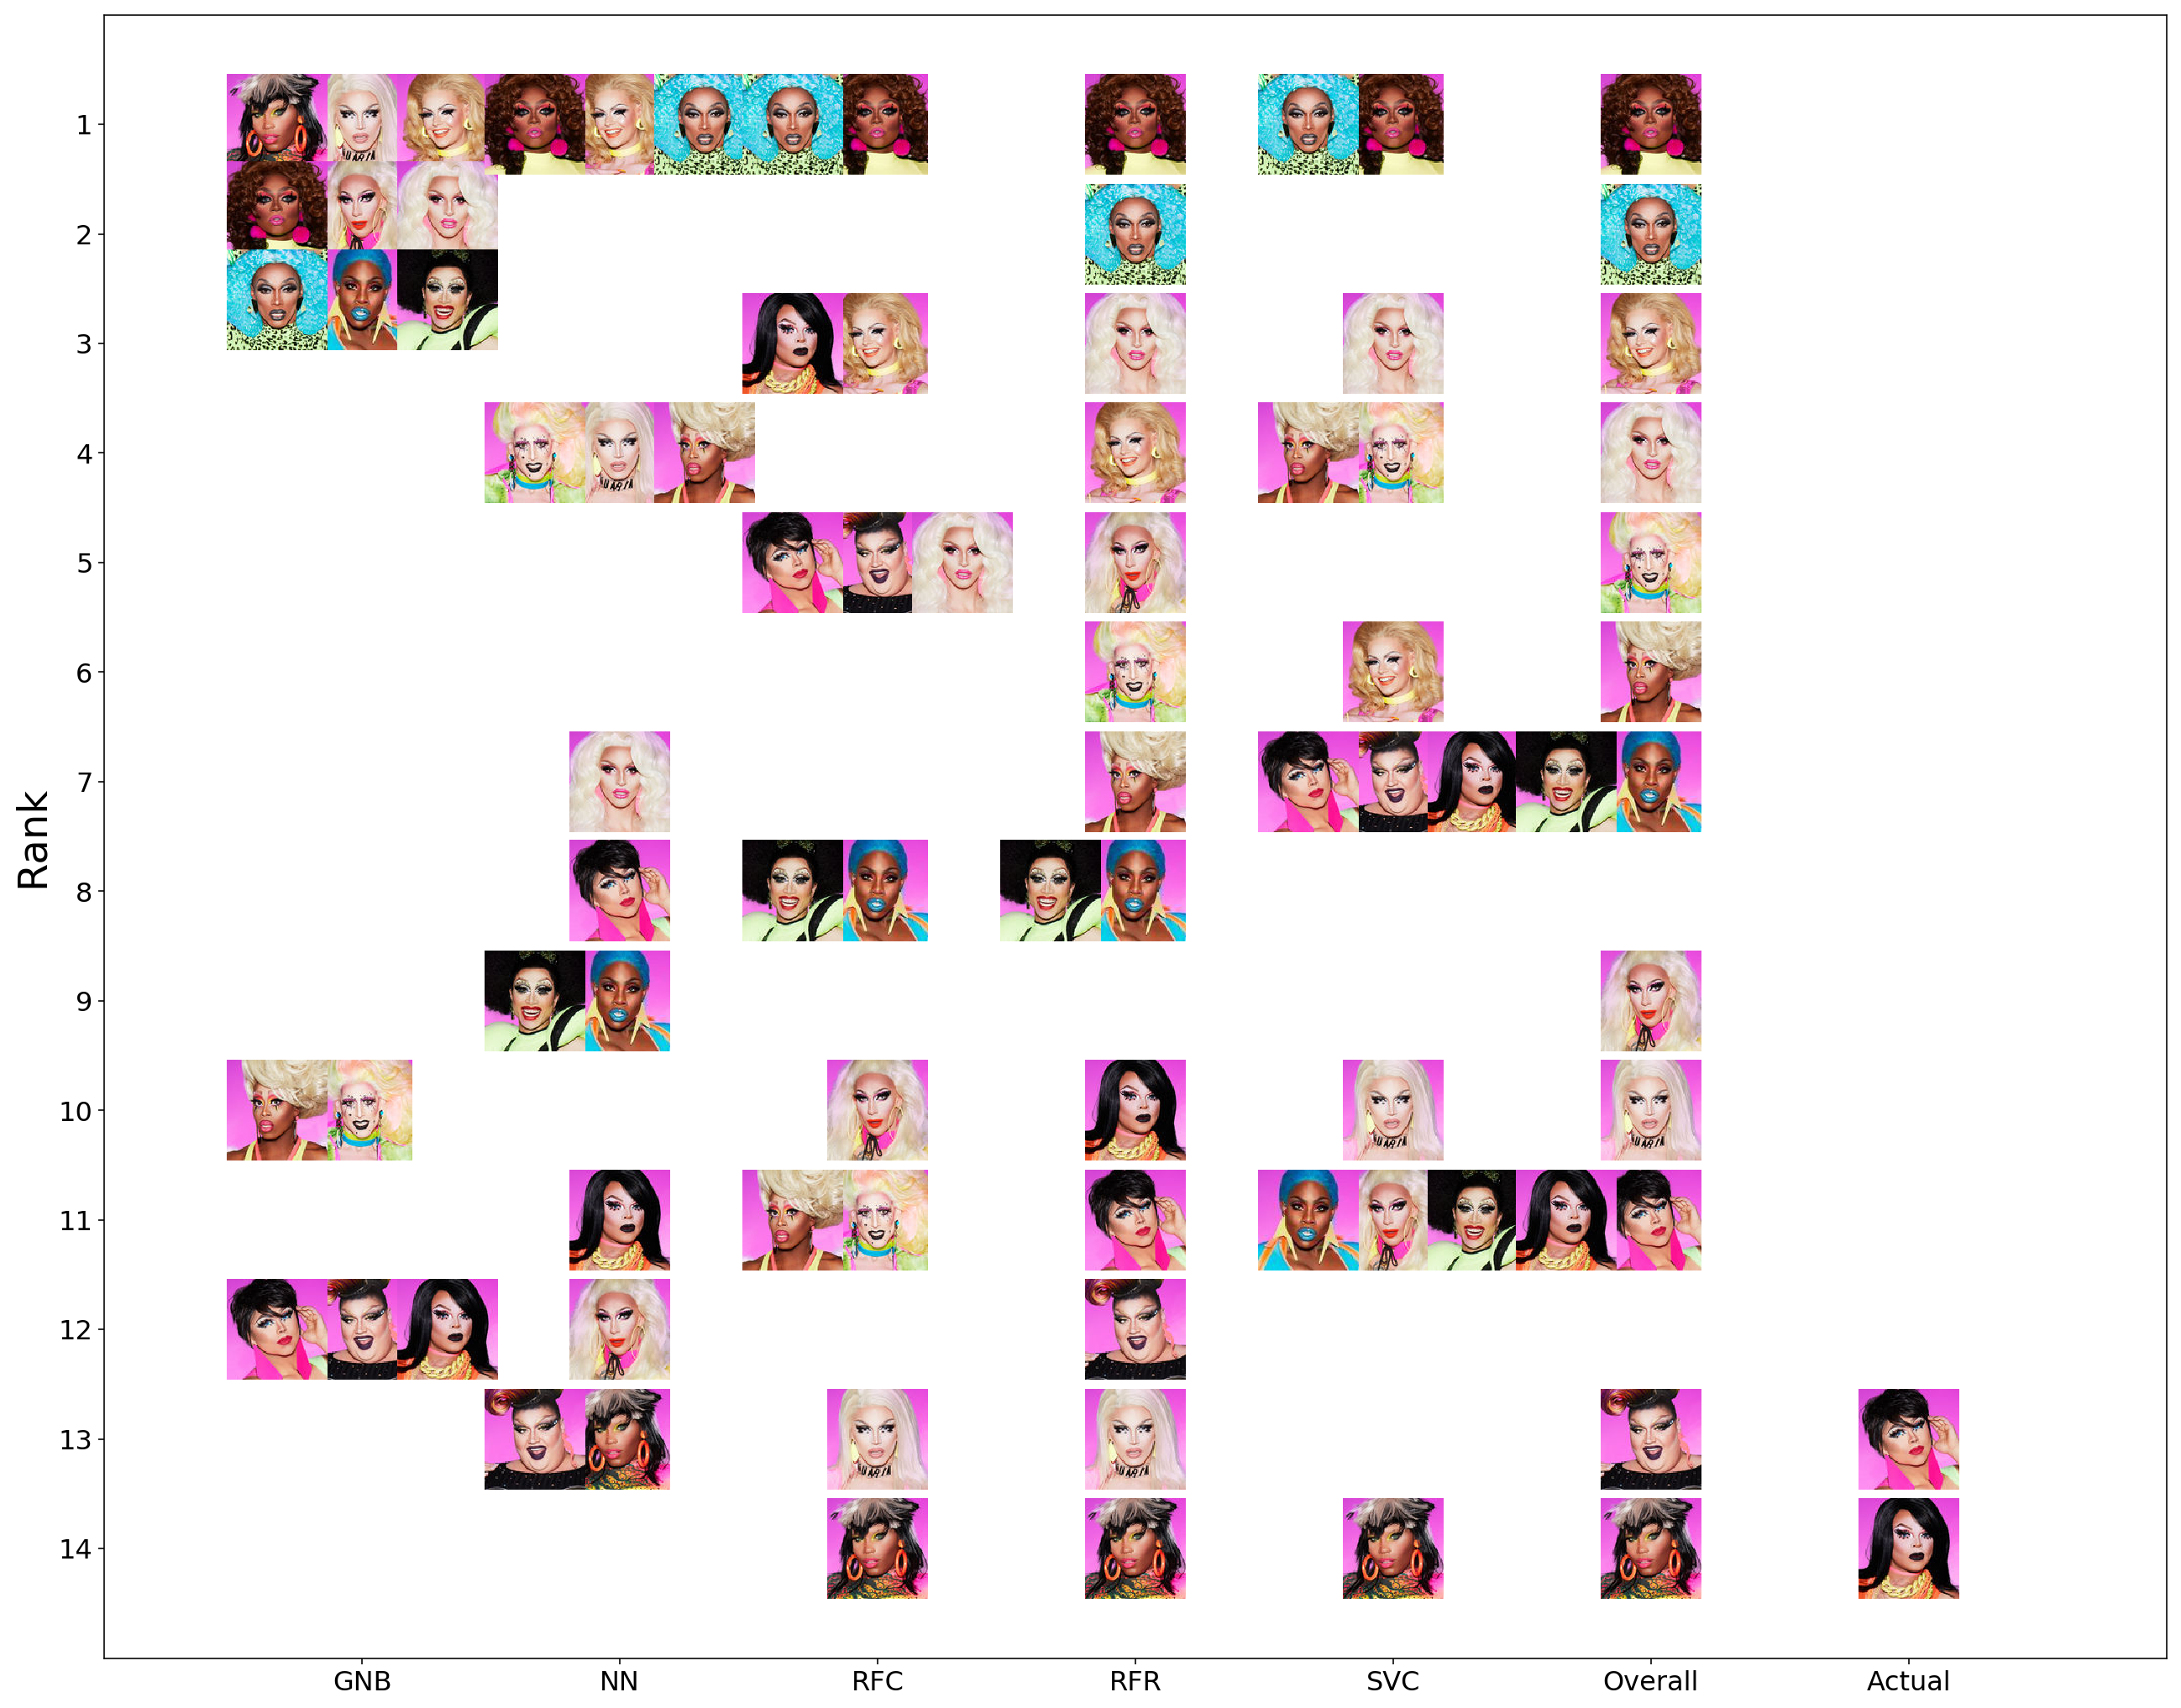

In [17]:


fig = plt.figure(figsize=(22,18))
ax = fig.add_subplot(1,1,1)
plt.xticks(range(7), ['GNB','NN','RFC','RFR','SVC','Overall','Actual'], size='small')
plt.yticks(range(14),range(14,0,-1))
ax.set_ylim([-1,14])
ax.set_xlim([-1,7])
ax.set_ylabel("Rank",fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

models = ['GNB','NN','RFC','RFR','SVC']

for i in range(5):
    the_data = pred_df.loc[pred_df.Model==models[i],:]
    places = {}
    for name in the_data.Name:
        file_name = filenames[name] + "Mug.jpg"
        place = 14-np.asscalar(the_data.loc[the_data.Name==name,'Predicted'])
        if place in places.keys():
            places[place]+=1
        else:
            places[place]=1
        img = mpimg.imread("Season 10 Queens/"+file_name)
        im = OffsetImage(img,zoom=0.6)
        x, y = setXY(i,place,places[place])
        ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
        ax.add_artist(ab)

the_data = resultsTable
places = {}
for name in the_data.Name:
    file_name = filenames[name] + "Mug.jpg"
    place = 14-np.asscalar(the_data.loc[the_data.Name==name,'PredPlace'])
    if place in places.keys():
        places[place]+=1
    else:
        places[place]=1
    img = mpimg.imread("Season 10 Queens/"+file_name)
    im = OffsetImage(img,zoom=0.6)
    x, y = setXY(5,place,places[place])
    ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
    ax.add_artist(ab)

places = {}
for name in the_data.Name:
    if np.asscalar(the_data.loc[the_data.Name==name,'Place']) != 0:
        file_name = filenames[name] + "Mug.jpg"
        place = 14-np.asscalar(the_data.loc[the_data.Name==name,'Place'])
        if place in places.keys():
            places[place]+=1
        else:
            places[place]=1
        img = mpimg.imread("Season 10 Queens/"+file_name)
        im = OffsetImage(img,zoom=0.6)
        x, y = setXY(6,place,places[place])
        ab = AnnotationBbox(im,(x,y),xycoords='data',frameon=False)
        ax.add_artist(ab)

fig.savefig("predicted10.png")